# LocusRegression Simulation Studies

This tutorial covers how to construct synthetic datasets, then train and evaluate LocusRegression models using those datasets. First, some imports: 

In [1]:
import numpy as np

### Transition matrix

To simulate some data according to the generative model proposed by LocusRegression, we first need to define ground-truth genomic states for each locus in a hypothetical genome. We assign states by sampling a chain from a predefined Markov transition matrix. The transition matrix should be of size $(N_{states}, N_{states})$, and have rowsums of 1.

In [2]:
transition_matrix = np.array([
    [0.99, 0.005, 0.005],
    [0.0, 0.97, 0.03],
    [0.015, 0.015, 0.97]
])

Each of these states will correspond with changes to some simluated genomic correlate. Next we define the distribution of each correlate. Correlates are simulated using the model:

$X_{s,\ell} \sim \textrm{Normal}(\mu \cdot \delta({\textrm{state}(\ell) - s)}, \sigma^2)$

where the correlate associated with state $s$ is centered at $\mu$ for loci in that state, and $0$ otherwise. These correlates are stardardized before modeling. We provide a matrix of $\mu$'s and $\sigma$'s, each with shape $(N_{states})$.

In [3]:
signal_means = np.array([1.,1.,1.])
signal_stds = np.array([0.3, 0.25, 0.5])

### Trinucleotide differences

To finish setting up the properties of each genomic state, we define state-specific priors over the trinucleotide content of loci in that state. The trinucleotide content of each locus is subsequently sampled from a Dirichlet distribution with the corresponding prior. The priors matrix must be of shape $(N_{states}, 32)$. Here, I provide uniform priors for each state with varying degrees of noise/sparsity:

In [4]:
trinuc_priors = np.array([
    np.ones(32) * 5.,
    np.ones(32) * 20,
    np.ones(32) * 10,
])

### $\beta$ matrix

Lastly, we need to relate those states and correlates to processes. For this, we define a $\beta$ matrix of size $(N_{processes}, N_{states})$, which relates how each process associates with genomic correlates:

In [5]:
beta_matrix = np.array([
    [1,-0.5,0],
    [-0.5,1,-0.5],
    [-0.5,-0.5,1],
    [1,-1,1],
    [0.,1.,1],
])

### Generating a simulated dataset

Now, we can use these generative parameters to construct a dataset. We provide the structured information outline above, along with parameters for:

* `n_cells` : the number of samples (called "cells" here in homage to ssDNA-seq)
* `log_mean_mutations`, `log_std_mutations`: parameters of the $\mathrm{LogNormal}$ distribution from which the number of mutations per cells are drawn
* `pi_prior` : prior for the dirichlet distribution from which compositions over processes are drawn for each cell
* `n_loci` : the number of genomic bins. 10Kb bins over the entire genome gives ~250K regions after filtering repetitive elements, centromeres, etc.
* `seed` : reproducably produces the same simulated dataset

And finally, we associate each process with a known signature from the COSMIC catalogue:

In [6]:
simulation_params = dict(
    state_transition_matrix = transition_matrix,
    beta_matrix = beta_matrix,
    trinucleotide_priors = trinuc_priors,
    signal_means= signal_means,
    n_cells = 100,
    log_mean_mutations = 6,
    log_std_mutations = 0.5, 
    pi_prior = 1,
    n_loci = 250000,
    cosmic_sigs=['SBS1','SBS93','SBS3','SBS5','SBS2'],
)

Save this configuration dictionary as a pickle file:

In [7]:
import pickle

with open('data/simulation_params_1.pkl','wb') as f:
    pickle.dump({**simulation_params, 'seed' : 10, 'corpus_name' : 'corpus1'}, f)

with open('data/simulation_params_2.pkl','wb') as f:
    pickle.dump({**simulation_params, 'seed' : 20, 'corpus_name' : 'corpus2',}, f)

Then run the `locusregression` command to sample a synthetic dataset.

In [8]:
!locusregression simulate --config data/simulation_params_1.pkl --prefix "data/tutorial.sim1."
!locusregression simulate --config data/simulation_params_2.pkl --prefix "data/tutorial.sim2."

Generating samples: 100%|█████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


The simulation method outputs the same "corpus" object which is used for real data, so we can treat real and simulated data exactly the same. Additionally, the simulation outputs `parameters`, which are the ground truth attributes of the dataset which governed the generative process.

## Modeling the dataset

You can either tune a model (most realistic):

In [23]:
!locusregression create-study \
    --corpuses data/tutorial.corpus.h5 \
    -min 3 -max 10 --tune-subsample \
    --study-name tutorial.1

[I 2023-10-29 16:28:46,101] Using an existing study with name 'tutorial.1' instead of creating a new one.


In [25]:
!for i in {1..10}; do locusregression run-trial tutorial.1 -i 20 > data/$i.log 2>&1 &; done

or just provide the number of topics and get started:

In [27]:
!locusregression model-train \
                 --corpuses data/tutorial.sim1.corpus.h5 data/tutorial.sim2.corpus.h5 \
                 --n-components=5 \
                 -v --eval-every 1 \
                 -sub 0.125 --batch-size 32 \
                 -o data/tutorial_model_no-tuning.pkl \
                 --num-epochs 60

INFO:LocusRegressor:  Epoch 2   complete. | Elapsed time: 0.48 seconds. | Bound: -1125859.61, improvement: 9354.09    
INFO:LocusRegressor:  Epoch 3   complete. | Elapsed time: 0.49 seconds. | Bound: -1117220.10, improvement: 8639.51    
INFO:LocusRegressor:  Epoch 4   complete. | Elapsed time: 0.45 seconds. | Bound: -1109812.86, improvement: 7407.24    
INFO:LocusRegressor:  Epoch 5   complete. | Elapsed time: 0.49 seconds. | Bound: -1105407.40, improvement: 4405.46    
INFO:LocusRegressor:  Epoch 6   complete. | Elapsed time: 0.50 seconds. | Bound: -1101930.08, improvement: 3477.32    
INFO:LocusRegressor:  Epoch 7   complete. | Elapsed time: 0.44 seconds. | Bound: -1099912.13, improvement: 2017.95    
INFO:LocusRegressor:  Epoch 8   complete. | Elapsed time: 0.46 seconds. | Bound: -1098162.69, improvement: 1749.44    
INFO:LocusRegressor:  Epoch 9   complete. | Elapsed time: 0.44 seconds. | Bound: -1096705.71, improvement: 1456.98    
INFO:LocusRegressor:  Epoch 10  complete. | Elap

If you went with the tuning option, study and plot the model scores versus the number of topics used:

In [3]:
from optuna.visualization.matplotlib import *
from locusregression import load_study
from IPython.display import Image

study, dataset, study_attrs = load_study('tutorial.1')

/Users/allenwlynch/miniconda3/envs/locusregression/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: title={'center': 'Slice Plot'}, xlabel='n_components', ylabel='Objective Value'>

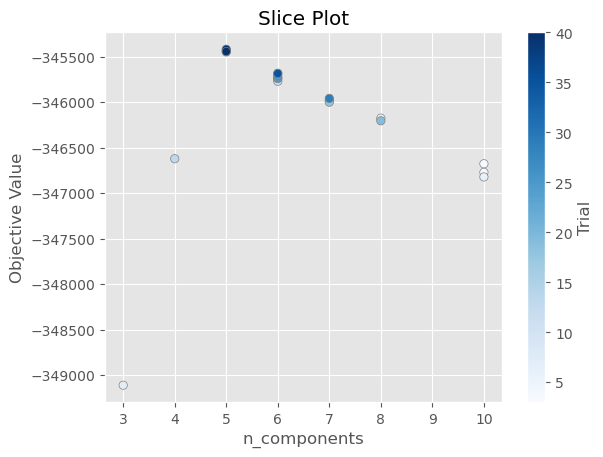

In [2]:
plot_slice(study, params = ['n_components'])

The best model had five topics, just like the simulation! The next command retrains a model on the whole dataset with the best hyperparameters found in the tuning stage. Instead of retraining the best model (by default), you can provide the trial number of a model you wish to train instead.

In [32]:
!locusregression retrain tutorial.1 -o data/tutorial_model.pkl

Training model with params:
	n_components: 5
	locus_subsample: 0.125
	seed: 95237200
	tau: 1
	kappa: 0.7
	batch_size: 70
INFO:LocusRegressor:  Epoch 40  complete. | Elapsed time: 0.47 seconds. | Bound: -543212.25, improvement: 3196.33    
INFO:LocusRegressor:  Epoch 60  complete. | Elapsed time: 0.47 seconds. | Bound: -542412.70, improvement: 799.55     
INFO:LocusRegressor:  Epoch 80  complete. | Elapsed time: 0.52 seconds. | Bound: -542145.87, improvement: 266.83     
INFO:LocusRegressor:  Epoch 100 complete. | Elapsed time: 0.49 seconds. | Bound: -542026.64, improvement: 119.23     
INFO:LocusRegressor:  Epoch 120 complete. | Elapsed time: 0.49 seconds. | Bound: -541961.65, improvement: 64.99      
INFO:LocusRegressor:  Epoch 140 complete. | Elapsed time: 0.57 seconds. | Bound: -541921.87, improvement: 39.78      
INFO:LocusRegressor:  Epoch 160 complete. | Elapsed time: 0.52 seconds. | Bound: -541894.85, improvement: 27.01      
INFO:LocusRegressor:  Epoch 180 complete. | Elapsed t

# Evaluation

I have some crude metrics implemented for evaluating the solution against the generative parameters. `coef_l1_distance` evaluates the mean $\mathrm{L1}$ distance between the the model's inferred $\beta$'s and the closest match with amongst the ground truth $\beta$'s. Next, the `signature_cosine_sim` is the average cosine similarity between each signature found by the model and the closest match signature in the ground thruth:

In [43]:
!locusregression eval-sim --model data/tutorial_model.pkl -sim data/tutorial.generative_params.pkl

coef_L1_dist	signature_cos_sim
0.08843849701647612	0.996320025870524


This model is very close to perfect. We can access important information from the trained model using the following series of commands.
First, to get the per-sample exposures to each component, use "model-predict", which saves a csv file with sample vcf filepaths and their normalized exposure to each component:

In [29]:
!locusregression model-predict data/tutorial_model.pkl \
                        -d data/tutorial.corpus.h5 \
                        > data/tutorial.predictions.csv
!head -n3 data/tutorial.predictions.csv

,Component 0,Component 1,Component 2,Component 3,Component 4
0,0.30069280253600184,0.47184855580497875,0.03721007756334462,0.11697302132840792,0.07327554276726678
1,0.12299368849495783,0.09825385839102703,0.2812218489368849,0.04511279990053025,0.4524178042766001


The next command, "model-summary", plots the association weights and signatures of each component:

In [28]:
!locusregression model-plot-summary data/tutorial_model_no-tuning.pkl -o data/model_summary.png

In [29]:
from IPython.display import Image

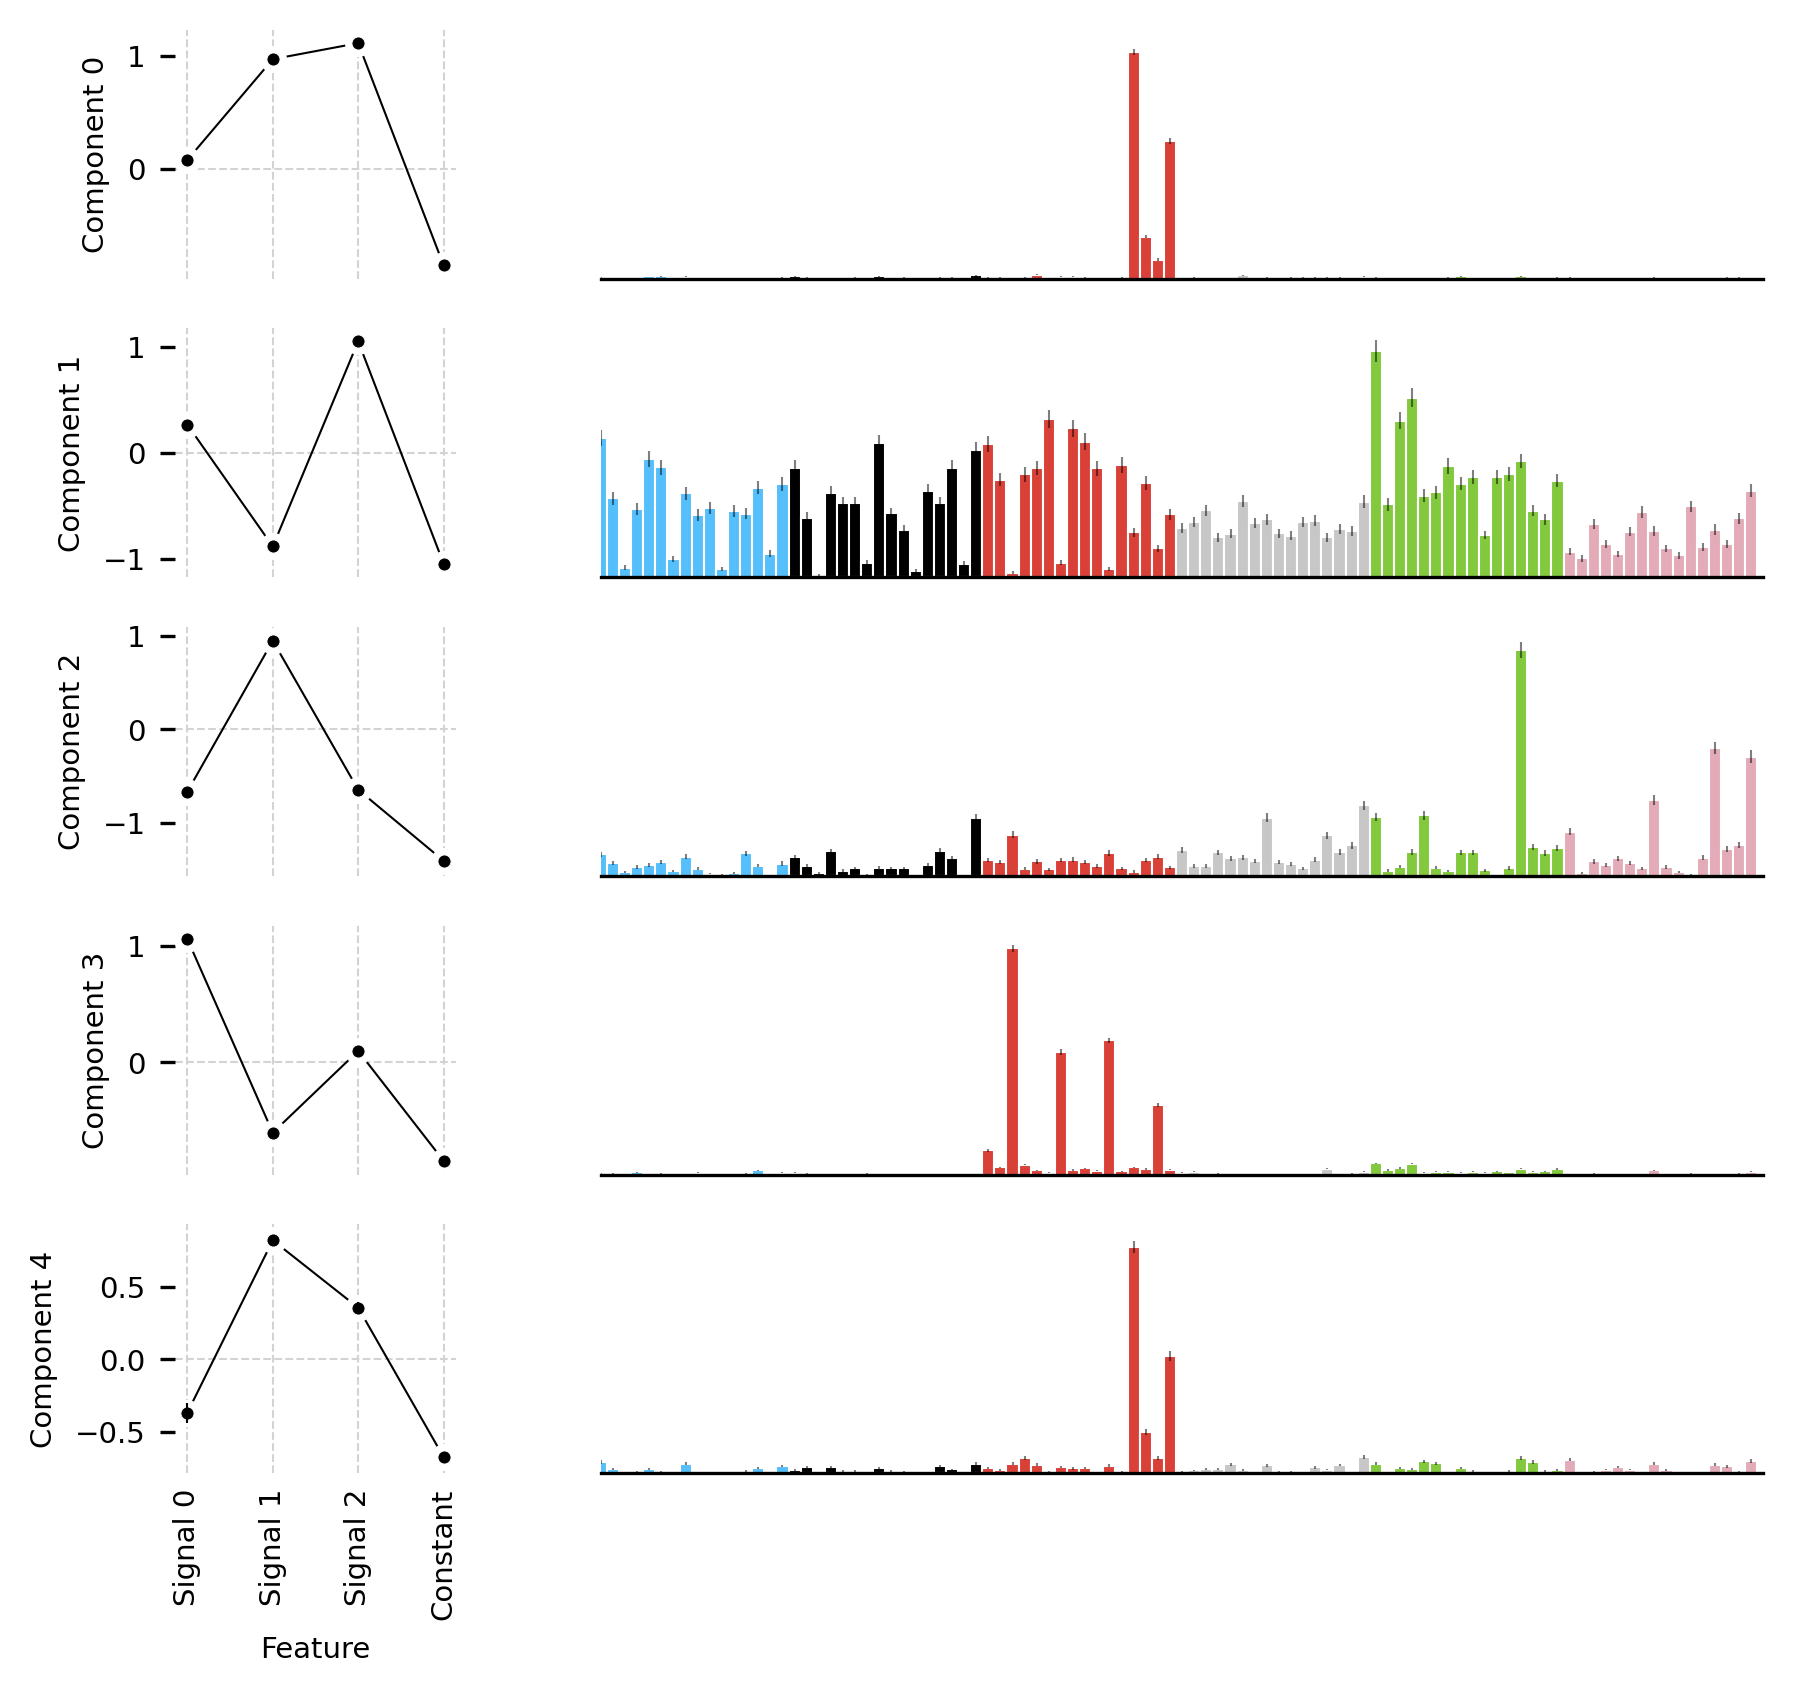

In [30]:
Image(filename='data/model_summary.png', width = 700)

"model-compare-coefs" clusters and plots a multidimensional comparison of all of the associations for each component. Try different values of "--cluster-distance/-dist" to control cluster coarseness. I find that many signatures have similar associations, so outliers are more interesting. By default, this plot colors the most common cluster grey so that outliers can be easily distinguished. 

In [16]:
!locusregression model-plot-coefs  data/tutorial_model.pkl \
                    -o data/model_compare_coefs.png \
                    -dist 1.5

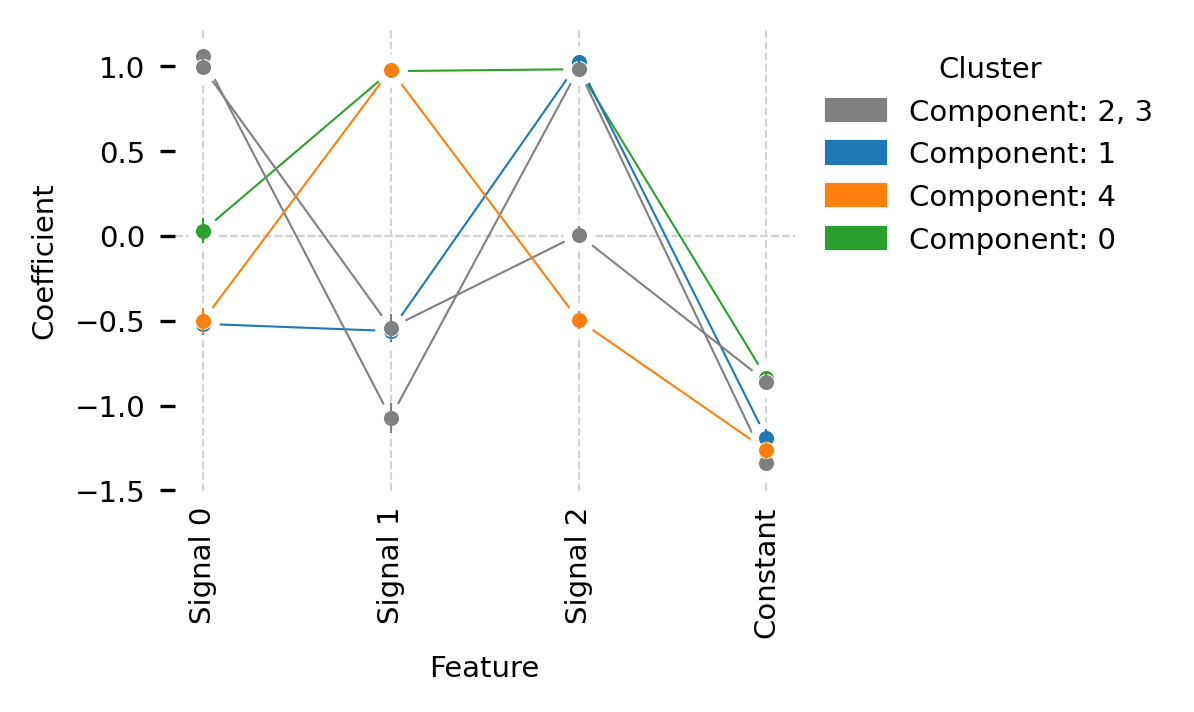

In [17]:
Image(filename='data/model_compare_coefs.png', width = 650)

In [67]:
!locusregression model-save-signatures data/tutorial_model.pkl -o data/tutorial_model_signatures.csv
!locusregression model-save-associations data/tutorial_model.pkl -o data/tutorial_model_associations.csv

In [1]:
from locusregression import *

model = load_model('data/tutorial_model_no-tuning.pkl')
corpus1 = stream_corpus('data/tutorial.sim1.corpus.h5')
corpus2 = stream_corpus('data/tutorial.sim2.corpus.h5')

/Users/allenwlynch/miniconda3/envs/locusregression/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import seaborn as sns

In [8]:
import numpy as np

In [9]:
np.exp( corpus1.get_empirical_mutation_rate() ).sum()

250002.31027452997

<Axes: >

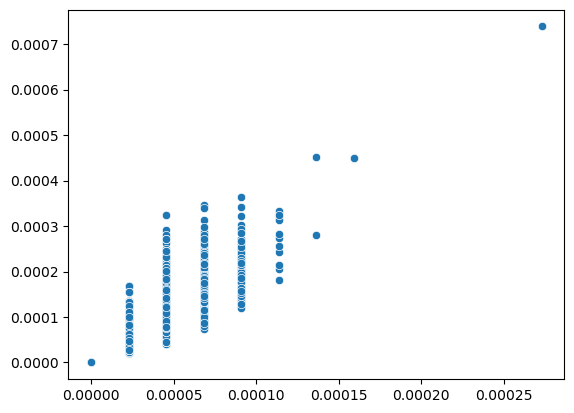

In [5]:
sns.scatterplot(
    x = corpus1.collapse_mutations().samples[0].get_empirical_mutation_rate(),
    y = corpus1.get_empirical_mutation_rate(),
)

In [2]:
import logging
logging.basicConfig(level=logging.INFO)
logger.setLevel(logging.INFO)

In [ ]:
newmodel = LocusRegressor(n_components=5, batch_size=32, locus_subsample=0.125, negative_subsample=None,eval_every=20, quiet=False,
                          num_epochs=80)\
    .fit(MetaCorpus(corpus2,corpus1))

INFO:LocusRegressor:  Epoch 1   complete. | Elapsed time: 0.58 seconds.
INFO:LocusRegressor:  Epoch 2   complete. | Elapsed time: 0.54 seconds.
INFO:LocusRegressor:  Epoch 3   complete. | Elapsed time: 0.51 seconds.
INFO:LocusRegressor:  Epoch 4   complete. | Elapsed time: 0.49 seconds.
INFO:LocusRegressor:  Epoch 5   complete. | Elapsed time: 0.46 seconds.
INFO:LocusRegressor:  Epoch 6   complete. | Elapsed time: 0.45 seconds.
INFO:LocusRegressor:  Epoch 7   complete. | Elapsed time: 0.45 seconds.
INFO:LocusRegressor:  Epoch 8   complete. | Elapsed time: 0.46 seconds.
INFO:LocusRegressor:  Epoch 9   complete. | Elapsed time: 0.47 seconds.
INFO:LocusRegressor:  Epoch 10  complete. | Elapsed time: 0.45 seconds.
INFO:LocusRegressor:  Epoch 11  complete. | Elapsed time: 0.46 seconds.
INFO:LocusRegressor:  Epoch 12  complete. | Elapsed time: 0.50 seconds.
INFO:LocusRegressor:Training interrupted by user.


In [4]:
newmodel = load_model('data/tutorial_model.joint.pkl')

In [5]:
import matplotlib.pyplot as plt
import numpy as np

array([[<Axes: ylabel='Component 0'>, <Axes: >],
       [<Axes: ylabel='Component 1'>, <Axes: >],
       [<Axes: ylabel='Component 2'>, <Axes: >],
       [<Axes: ylabel='Component 3'>, <Axes: >],
       [<Axes: xlabel='Feature', ylabel='Component 4'>, <Axes: >]],
      dtype=object)

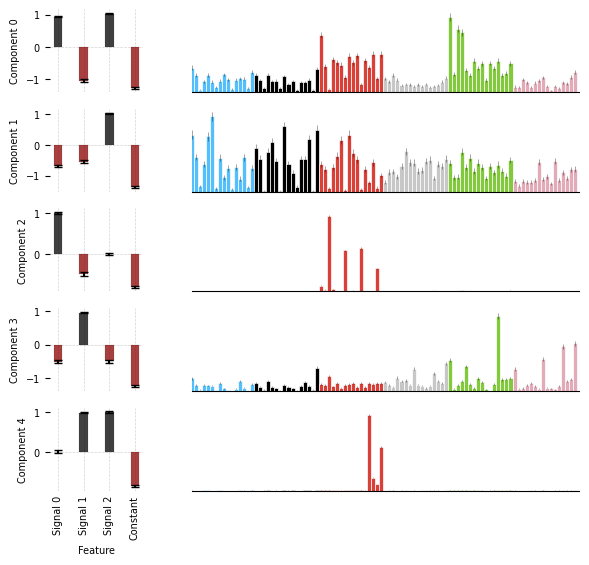

In [6]:
newmodel.plot_summary()

In [13]:
_ = newmodel.assign_mutations_to_components(corpus1[0], 'corpus1')

Sampling mutation assignments:   0%|                                        | 0/499 [00:00<?, ?it/s]

Sampling mutation assignments: 100%|█████████████████████████████| 499/499 [00:02<00:00, 183.06it/s]


In [15]:
model.assign_sample_to_corpus(corpus2[0])

Importance sampling iterations:   0%|                                       | 0/100 [00:00<?, ?it/s]

Importance sampling iterations: 100%|█████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


(['corpus1', 'corpus2'], array([-5715.58555324, -5424.59817009]))

In [115]:
from scipy.stats import poisson

In [154]:
prior = {(s1,s2) : abs(1 - s1) + abs(1 - s2) for s1 in range(4) for s2 in range(4)}
logits = np.array( list(prior.values()) )
unnormalized = np.exp( -20*logits )
prior_prob = unnormalized/unnormalized.sum()

In [155]:
ploidies = list(prior.keys())
total_cn = np.array([sum(ploidies[i]) for i in range(len(ploidies))])

In [156]:
obs_probs = np.exp( [poisson.logpmf(1,s1) + poisson.logpmf(2,s2) for s1,s2 in ploidies] )

joint = ( obs_probs * prior_prob )

In [157]:
num = joint[total_cn == 3].sum()
denom = joint.sum()

num/denom

4.549536236048865e-09

In [158]:
joint[ploidies.index((1,2))]/joint.sum()

3.0330241573659098e-09

#### Aggregated

In [159]:
obs_prob = np.exp( poisson.logpmf(3,total_cn) )
joint = obs_prob * prior_prob

In [160]:
num = joint[total_cn == 3].sum()
denom = joint.sum()

num/denom

5.11822825547518e-09

In [161]:
joint[ploidies.index((1,2))]/joint.sum()

2.55911412773759e-09